# Multiple Threading

- Author: *{{Fu}}*
- Update: *Dec 26, 2022*
- Reading: *120 min*

---




## Global Interpreter Lock

Because of the existence of `Global Interpreter Lock (GIL)`, multi-threads code in multi-cores system can only run one thread at a time. Each thread needs to `acquire` a lock before it can run, and after the thread finishes running, the lock is `released`, and another thread acquires the lock again. So multiple threading is sutiable for `IO bound` mission, not the `CPU bound` mission

```{figure} ../files/python_gil.webp
---
scale: 60%
align: center
name: python_gil
---
GIL in python
```

## threading

Now let's introduce the `threading` package in python.


### 1. create a thread, start a thread, and join function:

In [1]:
import threading
import time

def thread_job():
    print('thread_job start\n')
    print('This is a thread of %s \n' % threading.current_thread())
    print('thread_job finish\n')

def main():
    # add a new thread
    thread = threading.Thread(target=thread_job, name="thread_job")

    # start a thread
    thread.start()

    # wait this thread finished running, then run following code. Also called `block thread`
    thread.join()

    # see how many threads is running now
    print("There are", threading.active_count(), 'threads is running now\n') 

    # see the thread list
    print("The running threads list is:", threading.enumerate(), '\n') 

    # which one thread is running now
    print("The thread", threading.current_thread(), 'is running now\n') 

if __name__ == '__main__':
    main()

thread_job start

This is a thread of <Thread(thread_job, started 140209727465024)> 

thread_job finish

There are 7 threads is running now

The running threads list is: [<_MainThread(MainThread, started 140210481617792)>, <Thread(IOPub, started daemon 140210369500736)>, <Heartbeat(Heartbeat, started daemon 140210281117248)>, <Thread(Thread-3, started daemon 140210079790656)>, <Thread(Thread-4, started daemon 140210063009344)>, <ControlThread(Control, started daemon 140210046228032)>, <ParentPollerUnix(Thread-2, started daemon 140209744246336)>] 

The thread <_MainThread(MainThread, started 140210481617792)> is running now



### 2. quene function: get the results from multiple threads

In [2]:
import threading
import time
from queue import Queue

# do a function: square a number
def job(l,q):
    new_list = l.copy()
    for i in range(len(l)):
        new_list[i] = l[i]**2
    q.put(new_list)

def multithreading():
    # create a quene
    q = Queue()

    threads = []
    data = [[1,2,3],[3,4,5],[4,4,4],[5,5,5]]

    # create 4 threads
    for i in range(4):
        t = threading.Thread(target=job, args=(data[i], q))
        t.start()
        threads.append(t)

    for thread in threads:
        thread.join()
    
    # get the results from multi-threads
    results = []
    for _ in range(4):
          results.append(q.get())
    print("Input:", data)
    print("Output:", results)

if __name__ == '__main__':
    multithreading()

Input: [[1, 2, 3], [3, 4, 5], [4, 4, 4], [5, 5, 5]]
Output: [[1, 4, 9], [9, 16, 25], [16, 16, 16], [25, 25, 25]]


### 3. GIL is not suitable for `CPU bound` task:

In [3]:
import threading
from queue import Queue
import copy
import time

def job(l, q):
    res = sum(l)
    q.put(res)

def multithreading(l):
    q = Queue()
    threads = []
    for i in range(4):
        t = threading.Thread(target=job, args=(copy.copy(l), q), name='T%i' % i)
        t.start()
        threads.append(t)
    [t.join() for t in threads]
    total = 0
    for _ in range(4):
        total += q.get()
    print(total)

def normal(l):
    total = sum(l)
    print(total)

if __name__ == '__main__':
    l = list(range(1000000))
    s_t = time.time()
    normal(l*4)
    print('normal: ',time.time()-s_t)
    s_t = time.time()
    multithreading(l)
    print('multithreading: ', time.time()-s_t)

1999998000000
normal:  0.05403256416320801
1999998000000
multithreading:  0.05234026908874512


### 4. GIL lock function:

In [4]:
import threading

def job1():
    global A, lock
    lock.acquire()
    for i in range(10):
        A += 1
        print('job1', A)
    lock.release()

def job2():
    global A, lock
    lock.acquire()
    for i in range(10):
        A += 10
        print('job2', A)
    lock.release()

if __name__ == '__main__':
    lock = threading.Lock()
    A = 0
    t1 = threading.Thread(target=job1)
    t2 = threading.Thread(target=job2)
    t1.start()
    t2.start()
    t1.join()
    t2.join()

job1 1
job1 2
job1 3
job1 4
job1 5
job1 6
job1 7
job1 8
job1 9
job1 10
job2 20
job2 30
job2 40
job2 50
job2 60
job2 70
job2 80
job2 90
job2 100
job2 110


## ThreadPoolExecutor

A `thread pool` maintains multiple threads waiting for tasks to be allocated for `concurrent` execution by the supervising program. By maintaining a pool of threads, the model increases performance and avoids latency in execution due to frequent creation and destruction of threads for short-lived tasks. The number of available threads is tuned to the computing resources available to the program, such as a parallel task queue after completion of execution.

One benefit of a thread pool over creating a new thread for each task is that **thread creation and destruction overhead is restricted to the initial creation of the pool**, which may result in better performance and better system stability. Creating and destroying a thread and its associated resources can be an expensive process in terms of time. An excessive number of threads in reserve, however, wastes memory, and context-switching between the runnable threads invokes performance penalties.

```{figure} ../files/thread_pool.png
---
scale: 20%
align: center
name: thread_pool
---
Thread pool in python
```

Now let's introduce `concurrent.futures` package in python.

1. When `ThreadPoolExecutor` constructs an instance, pass in the `max_workers` parameter to set the maximum number of threads that can `run simultaneously` in the thread pool.
2. Use the `submit` function to submit the task (function name and parameters) that the thread needs to execute to the thread pool, and return the handle of the task (similar to files and drawing). Note that submit is `not blocked`, and returns immediately.
3. Through the task handle returned by the submit function, you can use the `done` method to determine whether the task is over. 
4. Use the `cancel` method to cancel the submitted task. If the task is already running in the thread pool, it cannot be canceled. In this example, the thread pool size is set to 0.2 and the task is already running, so the cancellation fails. If the size of the thread pool is changed to 0.1, then task1 is submitted first, and task2 is still waiting in line. At this time, it can be successfully canceled.
5. Use the `result` method to get the return value of the task. Note: **result method is blocked**.


:::{admonition} What's the different between `threading` and `concurrent.futures` packages?
- `threading` is a common used package in python with a low-level API.
- The `concurrent.futures` module encapsulates `thread` to provides a high-level interface for asynchronously executing callables. The asynchronous execution can be performed with threads, using `ThreadPoolExecutor`, or separate processes, using `ProcessPoolExecutor`. Both implement the same interface, which is defined by the abstract Executor class.
:::


### 1. create a thread pool, submit a task, get the results

In [5]:
import time
from concurrent.futures import ThreadPoolExecutor

def down_video(times):
    time.sleep(times)
    print("down video {}s finished".format(times))
    return times

# create a thread pool with max_workers threads
executor = ThreadPoolExecutor(max_workers=2)

# submit a task into thread pool，and submit function will return immediately with blocking
task1 = executor.submit(down_video, (0.2))
task2 = executor.submit(down_video, (0.1))

# `done` function is used to check whether the task is finished
print("task 1 is finished?：",task1.done())

# `cancel` function is used to cancel the task before the thread put into thread-pool 
print("cancel task 2：",task2.cancel())

time.sleep(1)
print("task 1 is finished?：",task1.done())

# `result` is used to get the results of a thread
print("task1's results: ", task1.result())

task 1 is finished?： False
cancel task 2： False


down video 0.1s finished


down video 0.2s finished


task 1 is finished?： True
task1's results:  0.2


### 2. as_completed function:

Although the `done` function provides a method for judging whether the task is over, it is not very practical, because we don't know when the thread ends, and we need to always judge whether each task is over. At this time, you can use the `as_completed` method to retrieve the results of all tasks at once.

The `as_completed` method is a generator that will block when no task is completed. When a certain task is completed, it can continue to execute the statement after the for loop, and then continue to block until all tasks end.

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

def download_video(index):
    time.sleep(0.1)
    print("download video {} finished at {}".format(index,time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())))
    return index

executor = ThreadPoolExecutor(max_workers=2)
urls = [1, 2, 3, 4, 5]
all_task = [executor.submit(download_video, (url)) for url in urls]

for task in as_completed(all_task):
    data = task.result()
    print("task {} down load success".format(data))

download video 1 finished at 2022-12-28 22:58:56
task 1 down load success
download video 2 finished at 2022-12-28 22:58:56
task 2 down load success


download video 3 finished at 2022-12-28 22:58:56
task 3 down load success
download video 4 finished at 2022-12-28 22:58:56
task 4 down load success
download video 5 finished at 2022-12-28 22:58:56
task 5 down load success


**Analysis:**
5 tasks, 2 threads. Since a maximum of 2 threads are allowed to be executed at the same time when the thread pool is constructed, task 1 and task 2 are executed at the same time. Judging from the output of heavy code, after task 1 and task 2 are executed, the for loop Enter the blocking state, until the end of task 1 or task 2, for will continue to execute task 3 / task 4, and ensure that only two tasks are executed at the same time.


### 3. map function:

The difference from the `as_completed` method is that the `map` method can guarantee **the order of tasks**. For example: if you download 5 videos at the same time, even if the second video is downloaded before the first video, it will be blocked and wait for the first video to download. After the completion and notification of the main thread, the second downloaded video will be notified back to the main thread to ensure that the tasks are completed in order. Here is an example to illustrate:

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

def download_video(index):
    time.sleep(index)
    print("download video {} finished at {}".format(index,time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())))
    return index

executor = ThreadPoolExecutor(max_workers=2)
urls = [0.3, 0.2, 0.1, 0.4, 0.5]
for data in executor.map(download_video,urls):
    print("task {} down load success".format(data))

download video 0.2 finished at 2022-12-28 22:58:56
download video 0.3 finished at 2022-12-28 22:58:56
task 0.3 down load success
task 0.2 down load success
download video 0.1 finished at 2022-12-28 22:58:56
task 0.1 down load success


download video 0.4 finished at 2022-12-28 22:58:57
task 0.4 down load success
download video 0.5 finished at 2022-12-28 22:58:57
task 0.5 down load success


### 4. wait function:

The `wait` method is somewhat similar to the thread `join` method, which can `block` the main thread until all the threads in the thread pool have completed their operations.

The `wait` method receives 3 parameters, the `waiting task sequence`, the `timeout time` and the `waiting condition`. The wait condition `return_when` defaults to `ALL_COMPLETED`, indicating that all tasks are to be completed. You can see that in the running results, all tasks are indeed completed, and the main thread prints out main. The waiting condition can also be set to `FIRST_COMPLETED`, indicating that the first task is completed and the wait is stopped.

In [8]:
from concurrent.futures import ThreadPoolExecutor, wait, ALL_COMPLETED, FIRST_COMPLETED
import time

def download_video(index):
    time.sleep(0.1)
    print("download video {} finished at {}".format(index,time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())))
    return index
executor = ThreadPoolExecutor(max_workers=2)
urls = [0.1, 0.2, 0.3, 0.4, 0.5]
all_task = [executor.submit(download_video,(url)) for url in urls]
wait(all_task,return_when=ALL_COMPLETED)
print("main ")

download video 0.1 finished at 2022-12-28 22:58:57
download video 0.2 finished at 2022-12-28 22:58:57
download video 0.3 finished at 2022-12-28 22:58:57
download video 0.4 finished at 2022-12-28 22:58:57
download video 0.5 finished at 2022-12-28 22:58:57


main 


## Http Downloder Project

In this project, I use a multi-threaded method to download large file data, and support breakpoint transmission.

:::{dropdown} Do you know how to transfer large data via `http`?
:color: info
:icon: info

- The first thing we think of is **data compression**. Usually, when a browser sends a request, it will carry an `Accept-Encoding` header field, which contains a list of compression formats supported by the browser, such as `gzip`, `deflate`, `br`, etc., so that the server can choose one of them. The compression algorithm is put into the `Content-Encoding` response header, and the original data is compressed and sent to the browser.

- `Chunked` transfer is to disassemble a large file, break it into multiple small blocks, and distribute these small blocks to the browser in batches, and the browser will assemble and restore them after receiving them. In this way, the browser and the server do not need to store all the files in the memory, only send and receive a small part each time, the network will not be occupied by large files for a long time, and resources such as memory and bandwidth are also saved. `Transfer-Encoding` and `Content-Length` are mutually exclusive, and these two fields cannot appear in the response message at the same time, and the transmission of a response message is either of known length or unknown length (chunked), this must be remembered.

- `Range Requests` allow the client to use a dedicated field in the request header to indicate that only a part of the file is fetched. The header must include `Accept-Ranges: bytes`.
:::




```{figure} ../files/http_transfer.png
---
scale: 60%
align: center
name: http_transfer
---
Transfer Big Data via Http 
```


:::{admonition} Difference between `urllib` and `requests` package in python
- `urllib3` is the most commonly used network service package in python.
- `requests` uses `urllib3` under the hood and make it even simpler to make requests and retrieve data, and it aims for an easier-to-use API.
:::

In [9]:
import os
import requests
from tqdm import tqdm
from faker import Faker
from retry import retry
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed


cpu_cores = os.cpu_count()
requests.packages.urllib3.disable_warnings()


class downloader_https():
    def __init__(self, url, show_info = True, resume=True, filename=None, num_threads=cpu_cores, timeout=10, chunk_size=1024*1000, header=None, proxies=None):
        """
        :param url: 下载地址
        :param filename: 指定下载文件名 不指定则根据url截取命名
        """
        self.url = url
        self.show_info = show_info
        self.resume = resume
        self.chunk_size = chunk_size  # 设置下载文件块大小 单位为字节（多线程下载时，一个线程下载一小块）
        self.filename = filename
        self.num_threads = num_threads
        self.proxies = proxies
        self.timeout = timeout
        self.file_type = None
        self.accept_ranges = None
        self.content_length = None
        self.transfer_encoding = None
        if header is None:
            self.header = {}
            self.header.setdefault('User-Agent', Faker().user_agent())
        elif 'User-Agent' not in header:
            self.header.setdefault('User-Agent', Faker().user_agent())
        else:
            self.header = header

    @retry(tries=3)
    def check_url(self):
        """
        判断url是否支持断点续传功能 and 是否支持多线程（文件内容是否为零）
        """
        # 文件处理
        _, filename = os.path.split(self.url)
        self.filename = self.filename or filename

        res = requests.head(self.url, headers=self.header, proxies=self.proxies, timeout=self.timeout, allow_redirects=True, verify=False)  # verify=False 关闭ssl双向验证，解决访问https报错问题

        if not (200 <= res.status_code < 400):
            raise Exception('Bad request!')

        headers = res.headers
        self.file_type = headers.get('Content-Type')
        self.accept_ranges = headers.get('Accept-Ranges')
        self.transfer_encoding = headers.get('Transfer-Encoding')

        if self.transfer_encoding == "chunked" or self.transfer_encoding == "gzip, chunked":
            self.num_threads = 1
            self.content_length = 0
        else:
            lengths = headers.get('Content-Length')
            if lengths == None:
                self.content_length = 0
            else:
                self.content_length = int(lengths)


    def get_range(self, start=0):
        """
        根据设置的缓存大小以及文件大小划分字节序列
        eg: [(0, 1023), (1024, 2047), (2048, 3071) ...]
        """
        if self.transfer_encoding == "chunked" or self.transfer_encoding == "gzip, chunked":
            _range = [(start, '')]
        else:
            lst = range(start, self.content_length, self.chunk_size)   
            _range = list(zip(lst[:-1], [i - 1 for i in lst[1:]]))
            _range.append((lst[-1], ''))

        return _range


    @retry(tries=5)
    def download_by_piece(self, _range):
        start, stop = _range
        headers = {**self.header, **{"Range": f"bytes={start}-{stop}"}} # merge

        res = requests.get(self.url, headers=headers, proxies=self.proxies, timeout=self.timeout, allow_redirects=True, verify=False)
        if res.status_code != 206:
            raise Exception(f'Request raise error, url: {self.url}, range: {_range}')
        return _range, res.content


    def download(self):
        start = 0
        self.check_url()

        if self.accept_ranges != "bytes":
            if self.show_info:
                print(f'--- Mission ---: {self.url} download from scratch || with single thread, do not support breakpoint resuming')
            
            file_path = Path(self.filename)

            res = requests.get(self.url, 
                                headers=self.header, 
                                proxies=self.proxies, 
                                timeout=self.timeout, 
                                allow_redirects=True, 
                                verify=False)

            if res.status_code != 206:
                raise Exception(f'Request raise error, url: {self.url}')
 
            # 将下载的块写入文件
            open(file_path, 'w').close()  # 生成0文件
            with open(self.filename, 'rb+') as fp:
                fp.seek(0)
                fp.write(res.content)

            if self.show_info:
                print(f'--- File ---: {self.filename} download completely')
        else:
            file_path = Path(self.filename)

            if self.resume:
                open(file_path, 'w+').close()
                start = 0
                if self.show_info:
                    print(f'--- Mission ---: {self.url} download from scratch || with {self.num_threads} threads, support breakpoint resuming')

            else:
                if file_path.exists():
                    # 文件已存在 并且支持断点续传，可以从现有文件基础上继续下载
                    start = file_path.lstat().st_size
                    if self.show_info:
                        print(f'--- Mission ---: {self.url} download from breakpoint || with {self.num_threads} threads, support breakpoint resuming')

                    # If file have already downloaded 
                    if start == self.content_length:
                        if self.show_info:
                            print(f'--- File ---: {self.filename} has already been downloaded completely')
                        return
                else:
                    open(file_path, 'w+').close() # 生成文件
                    start = 0
                    if self.show_info:
                        print(f'--- Mission ---: {self.url} download from scratch || with {self.num_threads} threads, support breakpoint resuming')

            # 初始化进度条
            if self.show_info:
                pbar = tqdm(total=self.content_length,
                        initial=start,
                        unit='B',
                        unit_scale=True,
                        desc=self.filename,
                        unit_divisor=1024)
            
            # 使用多线池来创建线程
            with ThreadPoolExecutor(max_workers=self.num_threads) as pool:
                res = [pool.submit(self.download_by_piece, r) for r in self.get_range(start=start)] # or use map function

                # 将下载的块写入文件
                with open(self.filename, 'rb+') as fp:
                    for item in as_completed(res):
                        _range, content = item.result()
                        start, stop = _range
                        fp.seek(start)
                        fp.write(content)
                        # 更新进度条
                        if self.show_info:
                            pbar.update(self.chunk_size)

            if self.show_info:
                pbar.close()
                print(f'--- File ---: {self.filename} download completely')


    def print(self):
        self.check_url()
        print( "self.url = ", self.url, '\n',
            "self.resume = ", self.resume, '\n',
            "self.chunk_size = ", self.chunk_size, '\n',  # 设置下载文件块大小 单位为字节（多线程下载时，一个线程下载一小块）
            "self.filename = ", self.filename, '\n',
            "self.num_threads = ", self.num_threads, '\n',
            "self.proxies = ", self.proxies, '\n',
            "self.timeout = ", self.timeout, '\n',
            "self.file_type = ", self.file_type, '\n',
            "self.accept_ranges = ", self.accept_ranges, '\n',
            "self.content_length = ", self.content_length, '\n',
            "self.transfer_encoding = ", self.transfer_encoding, '\n',
            "self.header = ", self.header
            )

if __name__ == '__main__':
    url = "https://github.com/OUCyf/Latex-Template-Rice-USTC/raw/gh-pages/main.pdf"
    d = downloader_https(url, 
            num_threads = 4,
            show_info = False,
            resume = True, 
            chunk_size = 1024*100, 
            filename = None,  
            header = None, 
            proxies = None, 
            timeout = 10)
    d.download()
    d.print()

self.url =  https://github.com/OUCyf/Latex-Template-Rice-USTC/raw/gh-pages/main.pdf 
 self.resume =  True 
 self.chunk_size =  102400 
 self.filename =  main.pdf 
 self.num_threads =  4 
 self.proxies =  None 
 self.timeout =  10 
 self.file_type =  application/octet-stream 
 self.accept_ranges =  bytes 
 self.content_length =  393563 
 self.transfer_encoding =  None 
 self.header =  {'User-Agent': 'Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 5.0; Trident/4.0)'}


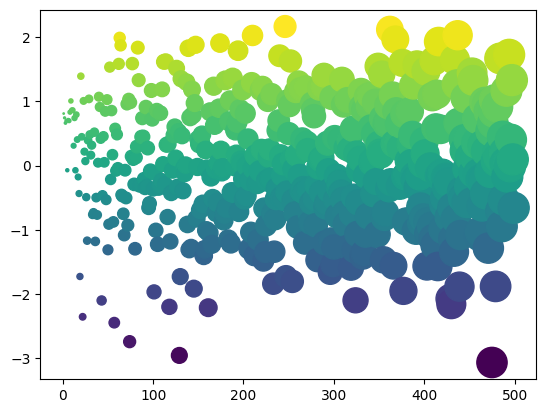

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

x = np.arange(500)
y = np.random.randn(500)

fig, ax = plt.subplots()
ax.scatter(x, y, c=y, s=x)

## Reference

1. https://www.codersrc.com/archives/6707.html
2. https://github.com/MorvanZhou/tutorials/tree/master/threadingTUT
3. https://www.cnblogs.com/traditional/p/15373999.html
4. https://www.51cto.com/article/665492.html
5. https://github.com/wikizero/downloader